# Figure - exp examples

In [1]:
import os
work_dir = "H:/workspace/ptyrad_paper"
os.chdir(work_dir)
print("Current working dir: ", os.getcwd())

Current working dir:  H:\workspace\ptyrad_paper


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift
from tifffile import imread, imwrite

from ptyrad.load import load_pt
from ptyrad.utils.image_proc import center_crop
from ptyrad.utils.math_ops import mfft2

In [3]:
# Define model data as a dictionary

reconstructions = {
    "MOSS6": {
        "title": 'MOSS-6',
        "path": "03_output/MOSS6/20250210_full_N65536_dp128_flipT100_random512_p2_1obj_5slice_dz40_Adam_plr1e-5_oplr5e-4_dpblur1_orblur0.5_ozblur1_opos_sng1.0_spr0.1/model_iter0020.pt",
        "dose": 100,
        "crop_param": [384, 384] # This is for final real space display only, the FFT is calculated with nearly the full size image for better k-space sampling
    },
    "ZSM5": {
        "title": 'ZSM-5',
        "path": "03_output/ZSM5/20250204_full_N16384_dp128_flipT100_random32_p6_1obj_8slice_dz40_Adam_ps10_ss50_plr1e-4_oalr5e-4_oplr5e-4_slr5e-4_ozblur1_oathr0.98_opos_sng1.0_spr0.1_tilt-1.2_4.7/model_iter2000.pt",
        "dose": 3500,
        "crop_param": [142, 142]
    },
    "tBL_WSe2": {
        "title": 'tBL-WSe$_2$',
        "path": "03_output/tBL_WSe2/20250131_ptyrad_convergence/full_N16384_dp128_flipT100_random16_p12_1obj_6slice_dz2_Adam_plr1e-4_oalr5e-4_oplr5e-4_slr5e-4_orblur0.5_ozblur1_oathr0.98_opos_sng1.0_spr0.1_aff1_0_-3_0/model_iter4000.pt",
        "dose": 7.55e5,
        "crop_param": [192, 192]
    },
    "PSO": {
        "title": 'PrScO$_3$',
        "path": "03_output/PSO/20250224_full_N4096_dp256_sparse32_p8_1obj_21slice_dz10_Adam_plr1e-4_oalr5e-4_oplr5e-4_slr5e-4_dpblur1_orblur0.4_ozblur1_mamp0.03_4_oathr0.96_oposc_sng1.0_spr0.1_continue/model_iter2000.pt",
        "dose": 1.22e6,
        "crop_param": [136*2, 136*2]
    }
}

# Load reconstructions and add relevant entries back to the dict
for name, data in reconstructions.items():
    
    print(f"\nCurrently processing: {name}")
    # Load model checkpoints
    ckpt = load_pt(data["path"])

    # Get dx_size and thickness from ckpt
    dx_size   = ckpt['model_attributes']['dx'].cpu().numpy()[()]
    thickness = ckpt['model_attributes']['slice_thickness'] * ckpt['optimizable_tensors']['objp'].shape[1]/10
    data["dx_size"] = dx_size
    data["thickness"] = thickness
    print(f"Loaded dx_size = {dx_size:.4f} Ang, thickness = {thickness:.2g} nm")
    
    # Extract and store object
    obj = ckpt["optimizable_tensors"]["objp"].detach().squeeze().cpu().numpy().sum(0)
    data["obj"] = obj
    print(f"Loaded obj.shape = {obj.shape}, obj.dtype = {obj.dtype}")

    # Compute FFT and dk size
    crop_side = min(obj.shape)
    fft = np.log(np.abs(fftshift(mfft2(center_crop(obj, crop_side, crop_side))[0]))) # FFT is calculated on nearly the full size obj for finer k-space sampling
    dk = 1 / (dx_size * crop_side)
    if name == 'PSO':
        fft = center_crop(fft, fft.shape[-2]*3//4, fft.shape[-1]*3//4) # PSO is padde so really no need to show the whole extended FFT range
    data["crop_side"] = crop_side
    data["fft"] = fft
    data["dk_size"] = dk
    print(f'Crop the object as square with side length = {crop_side} px before FFT, so the FFT would have finer k-sampling due to larger N (comparing to the displayed obj range)')
    print(f'fft.shape={fft.shape}, fft.dtype={fft.dtype}, dk = 1/(N*dx) = {dk:.6f} 1/Ang')

    # Get crop ranges
    # # Back-up code if we don't know how much to crop
    # crop_pos = ckpt['model_attributes']['crop_pos'].cpu().numpy()
    # ymin, ymax, xmin, xmax = crop_pos[:, 0].min(), crop_pos[:, 0].max(), crop_pos[:, 1].min(), crop_pos[:, 1].max()
    # crop_height, crop_width = ymax - ymin, xmax - xmin
    
    crop_height, crop_width = data['crop_param']
    crop_obj = center_crop(obj, crop_height, crop_width)
    data["crop_obj"] = crop_obj
    print(f'Crop the obj image into reasonable display range with crop_height = {crop_height}, crop_width = {crop_width}]') # Note that this cropping has no effect on the FFT or image scale bar
    print(f'crop_obj.shape = {crop_obj.shape}, dtype={crop_obj.dtype}')
    
    # Save everything back into reconstructions dict
    reconstructions[name] = data


Currently processing: MOSS6
Success! Loaded .pt file path = 03_output/MOSS6/20250210_full_N65536_dp128_flipT100_random512_p2_1obj_5slice_dz40_Adam_plr1e-5_oplr5e-4_dpblur1_orblur0.5_ozblur1_opos_sng1.0_spr0.1/model_iter0020.pt
Loaded dx_size = 0.2962 Ang, thickness = 20 nm
Loaded obj.shape = (1240, 1240), obj.dtype = float32
Crop the object as square with side length = 1240 px before FFT, so the FFT would have finer k-sampling due to larger N (comparing to the displayed obj range)
fft.shape=(1240, 1240), fft.dtype=float64, dk = 1/(N*dx) = 0.002723 1/Ang
Crop the obj image into reasonable display range with crop_height = 384, crop_width = 384]
crop_obj.shape = (384, 384), dtype=float32

Currently processing: ZSM5
Success! Loaded .pt file path = 03_output/ZSM5/20250204_full_N16384_dp128_flipT100_random32_p6_1obj_8slice_dz40_Adam_ps10_ss50_plr1e-4_oalr5e-4_oplr5e-4_slr5e-4_ozblur1_oathr0.98_opos_sng1.0_spr0.1_tilt-1.2_4.7/model_iter2000.pt
Loaded dx_size = 0.3591 Ang, thickness = 32 nm
L

In [4]:
# Iterate through reconstructions dynamically
for i, (name, data) in enumerate(reconstructions.items()):
    if i >= 4:
        break  # Only process the first 4 reconstructions for top row

    title = data['title']
    obj = data['crop_obj']
    dx_size = data['dx_size']
    dose = data['dose']
    thickness = data['thickness']
    fft = data['fft']
    dk_size = data['dk_size']
    
    # imwrite(f'fft_{name}_dk{dk_size:.5f}.tif', np.float32(fft))

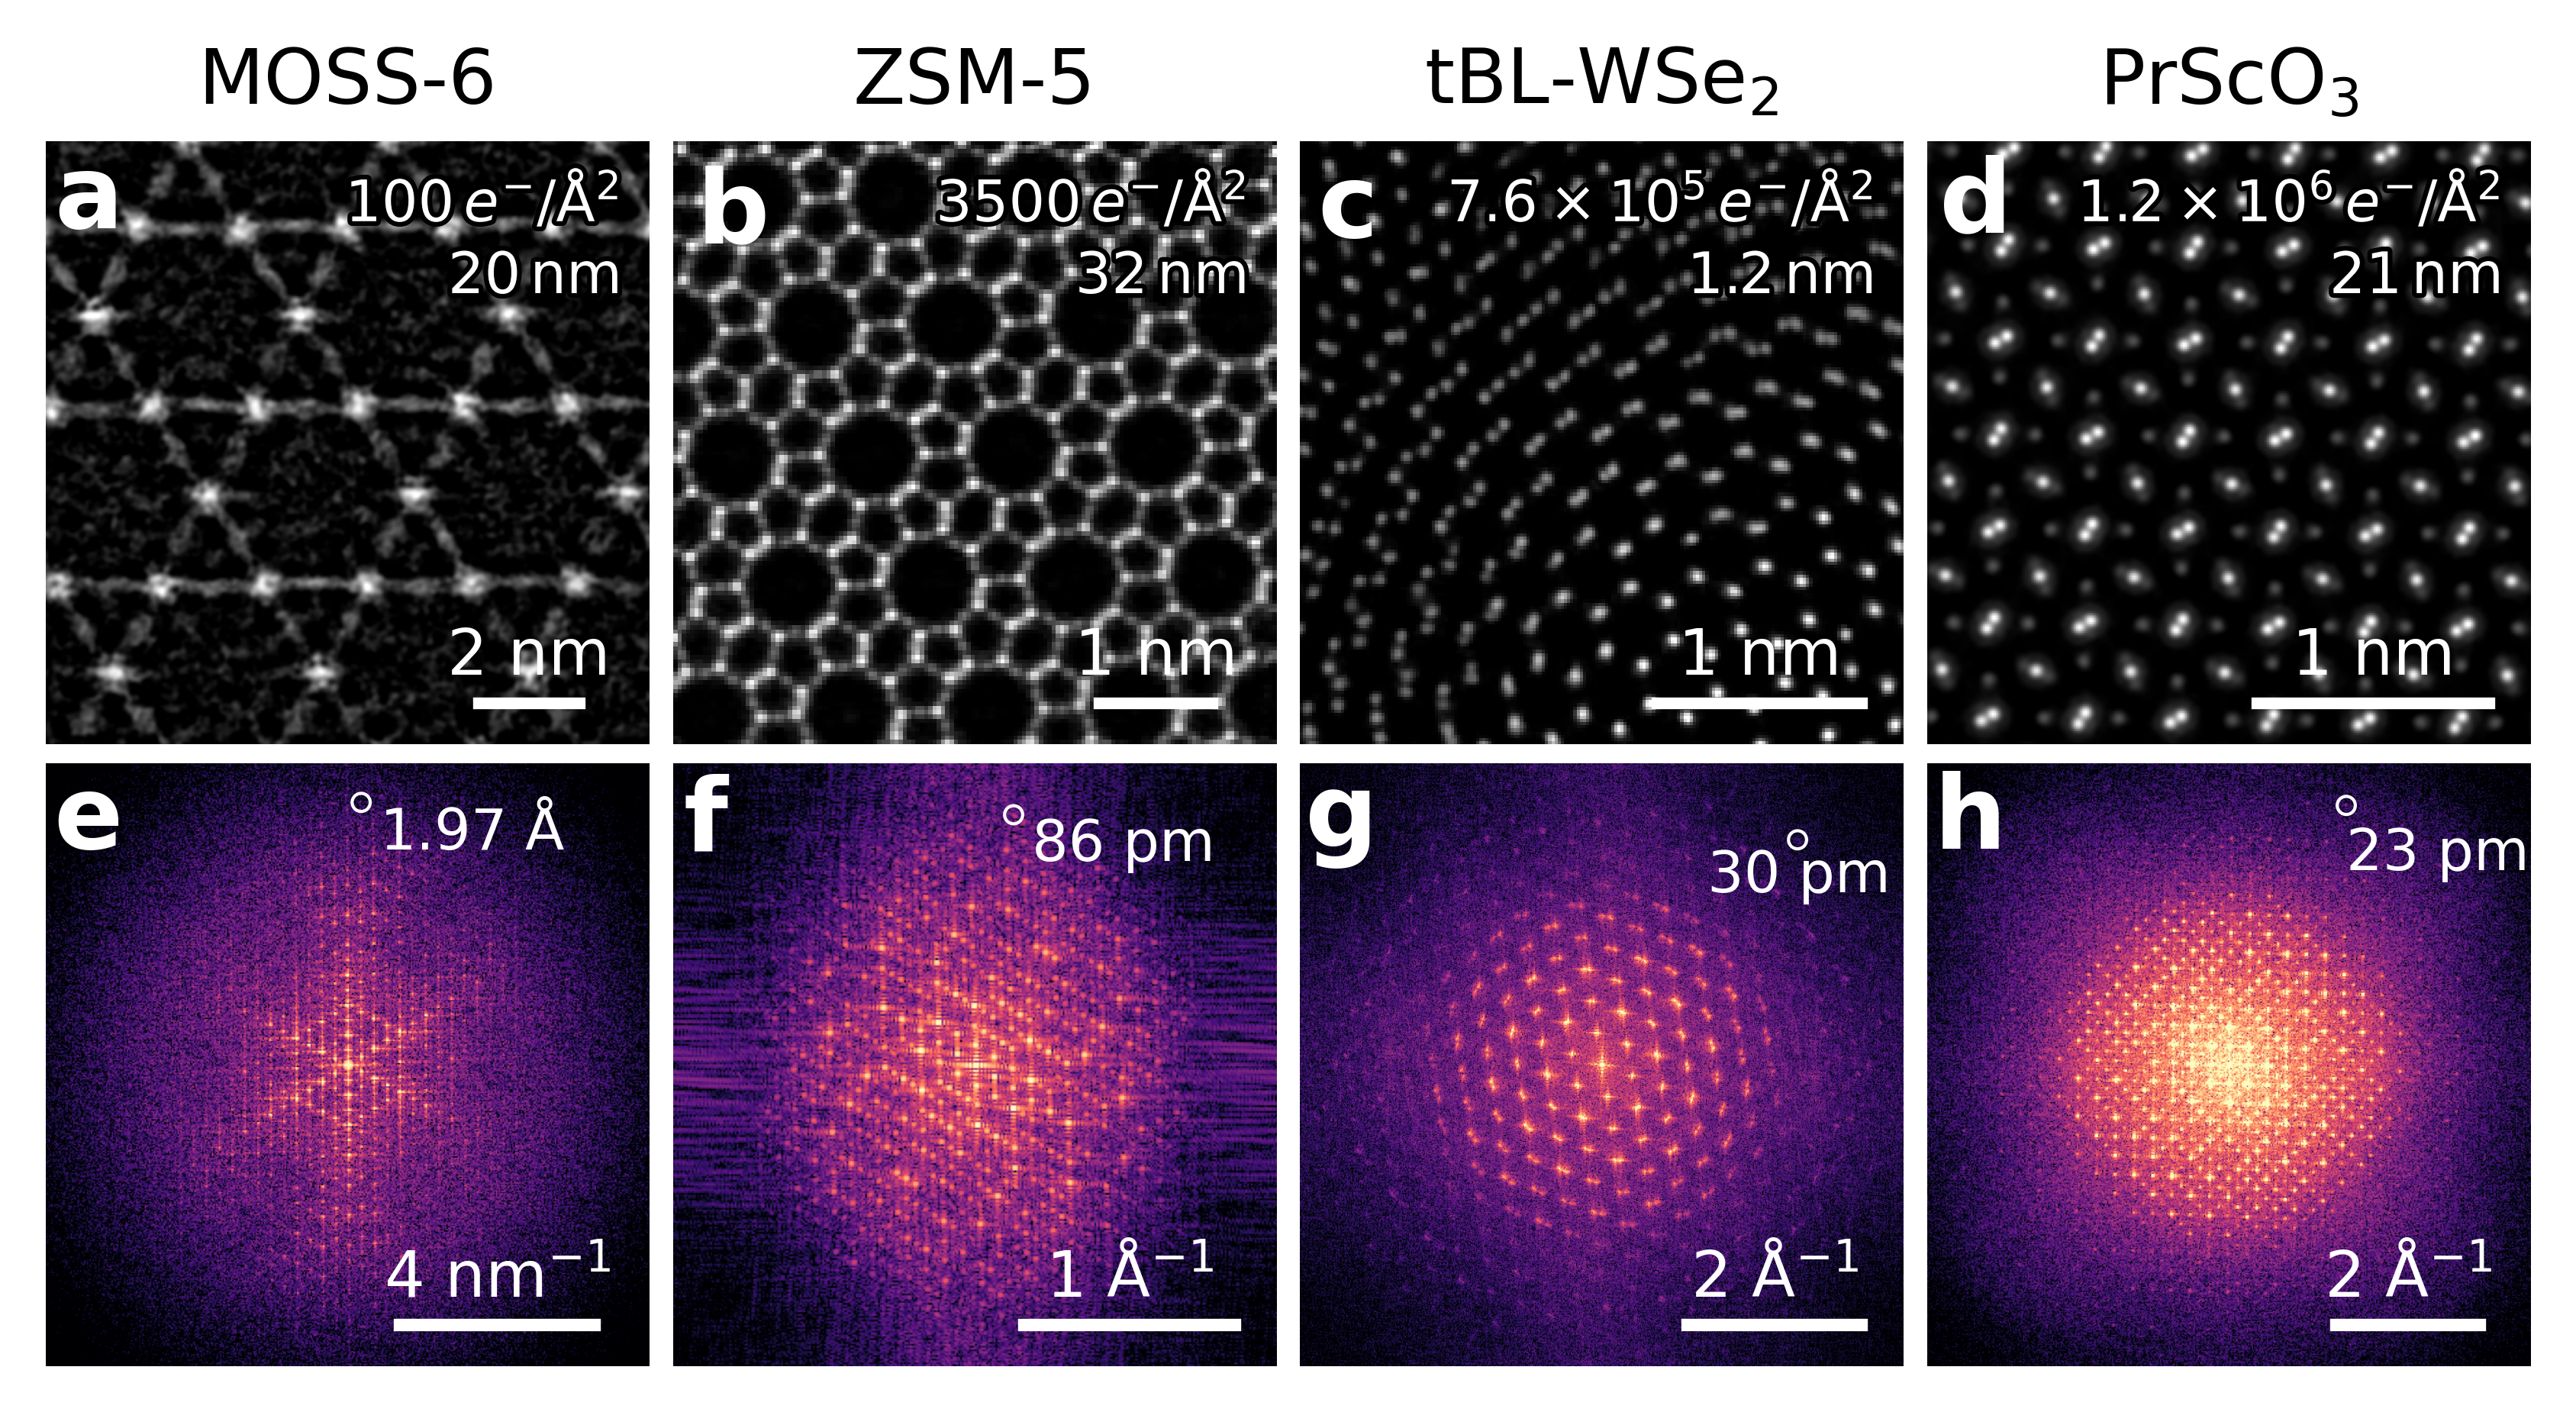

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects
from matplotlib.patches import Circle

# Create figure with GridSpec
fig = plt.figure(figsize=(7, 3.5), dpi=600)
gs = GridSpec(2, 4, figure=fig, wspace=0.04, hspace=0.015)  # Control spacing

# Titles for the columns
panel_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
shadow_offset = (0.01, -0.01)  # Relative unit

# Information limit
circle_labels = ['1.97 $\\mathrm{{\\AA}}$', '86 pm', '30 pm', '23 pm']
circle_positions = [[0.523,0.935],[0.565,0.9145],[0.825,0.873],[0.695,0.930]]
circle_text_offsets = [[0.03,-0.05],[0.03,-0.05],[-0.15,-0.06],[0,-0.08]]
circle_radius = 0.015

# Iterate through reconstructions dynamically
for i, (name, data) in enumerate(reconstructions.items()):
    if i >= 4:
        break  # Only process the first 4 reconstructions for top row
    
    ax = fig.add_subplot(gs[0, i])
    label = panel_labels[i]

    title = data['title']
    obj = data['crop_obj']
    dx_size = data['dx_size']
    dose = data['dose']
    thickness = data['thickness']
    fft = data['fft']
    dk_size = data['dk_size']
    
    # Scale bar settings
    scale_bar_length = (20 if i == 0 else 10) / dx_size
    scale_bar_label = "2 nm" if i == 0 else "1 nm"
    fontprops = fm.FontProperties(size=10)
    
    # Main image
    vmin, vmax = np.percentile(obj, [1, 99.95])
    ax.imshow(obj, cmap='gray', origin='upper', vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=12)
    ax.axis('off')
    
    # Panel label with shadow
    ax.text(5 + shadow_offset[0], 5 + shadow_offset[1], label, color='black', fontsize=16, fontweight='bold', va='top', ha='left', alpha=0.6)
    ax.text(5, 5, label, color='white', fontsize=16, fontweight='bold', va='top', ha='left')
    
    # Dose label formatting
    if i < 2:
        dose_label = f'${dose}\\,e^{{-}}/\\mathrm{{\\AA}}^{{2}}$'
    else:
        coef, exp = f"{dose:.1e}".split("e")
        dose_label = f"${coef} \\times 10^{{{int(exp)}}}\\,e^{{-}}/\\mathrm{{\\AA}}^{{2}}$"
    thickness_label = f"${thickness:.2g}\\,\\mathrm{{nm}}$"
    
    # Define path effects for outlined text
    outline_effect = [path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()]
    
    # Place dose and thickness labels
    text = ax.text(0.95, 0.95, dose_label, color='white', fontsize=9, fontweight='bold', va='top', ha='right', transform=ax.transAxes)
    text.set_path_effects(outline_effect)
    text = ax.text(0.95, 0.82, thickness_label, color='white', fontsize=9, fontweight='bold', va='top', ha='right', transform=ax.transAxes)
    text.set_path_effects(outline_effect)
    
    # Scale bar
    scalebar = AnchoredSizeBar(ax.transData, scale_bar_length, scale_bar_label,
                               loc='lower right', pad=0.5, color="white", frameon=False,
                               size_vertical=obj.shape[0] * 0.01, label_top=True, fontproperties=fontprops)
    ax.add_artist(scalebar)
    
    # FFT Processing (Bottom row)
    ax_fft = fig.add_subplot(gs[1, i])
    
    # Scale bar settings for FFT
    if i == 0:
        scale_bar_length = 0.4 / dk_size
        scale_bar_label = "4 nm$^{-1}$"
        fft = center_crop(fft, 440, 440)  # Crop the center part of fft for display. This doesn't change the dk pixel size
    elif i == 1:
        scale_bar_length = 1 / dk_size
        scale_bar_label = "1 $\\mathrm{\\AA}^{-1}$"
    else:
        scale_bar_length = 2 / dk_size
        scale_bar_label = "2 $\\mathrm{\\AA}^{-1}$"
    
    # Main FFT image
    if i == 0:
        vmin, vmax = np.percentile(fft, [20, 99.95])
    elif i == 3:
        vmin, vmax = np.percentile(fft, [10, 99.])
    else:
        vmin, vmax = np.percentile(fft, [10, 99.95])
    ax_fft.imshow(fft, cmap='magma', vmin=vmin, vmax=vmax)
    ax_fft.axis('off')
    
    # Add a white circle and label to FFT panels (e, f, g, h)
    circle = Circle(circle_positions[i], circle_radius, transform=ax_fft.transAxes,
                color='white', fill=False, linewidth=0.5)
    ax_fft.add_patch(circle)

    # Add a text label near the circle
    ax_fft.text(circle_positions[i][0]+circle_text_offsets[i][0], circle_positions[i][1]+circle_text_offsets[i][1], circle_labels[i], transform=ax_fft.transAxes, color='white', fontsize=9, va='center', ha='left')
    
    # Panel label with shadow
    ax_fft.text(5 + shadow_offset[0], 5 + shadow_offset[1], panel_labels[i + 4], color='black', fontsize=16, fontweight='bold', va='top', ha='left', alpha=0.6)
    ax_fft.text(5, 5, panel_labels[i + 4], color='white', fontsize=16, fontweight='bold', va='top', ha='left')
    
    # Scale bar for FFT
    scalebar = AnchoredSizeBar(ax_fft.transData, scale_bar_length, scale_bar_label,
                               loc='lower right', pad=0.5, color="white", frameon=False,
                               size_vertical=fft.shape[0] * 0.01, label_top=True, fontproperties=fontprops)
    ax_fft.add_artist(scalebar)

plt.savefig("05_figures/Fig_02_exp_examples.pdf", bbox_inches="tight")
plt.savefig("05_figures/Fig_02_exp_examples.png", bbox_inches="tight")
# Show the plot
plt.show()
